In [1]:
import os
import gymnasium as gym
import flappy_bird_gymnasium as flappy_bird
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import deque, defaultdict
from gymnasium.wrappers import RecordVideo

import sys
sys.path.append(os.path.abspath("../"))

from model import DQN_CNN
from save_model.utils import transition
import tqdm


plt.rcParams["figure.figsize"] = (10, 5)


/Users/stefaniancu/Documents/Q-learning-CNN-in-Flappy-Bird-Environment/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
MODEL_PATH = "../../checkpoints/65a798e19ae9839f79aaa52c1bde3cb5"
ENV_NAME = "FlappyBird-v0"
DEVICE = "cpu"

NUM_EPISODES = 100
FRAME_SKIP = 4
MAX_STEPS = 10_000  # safety cap


In [3]:
policy_net = DQN_CNN(FRAME_SKIP).to(DEVICE)
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
policy_net.load_state_dict(checkpoint["policy_net_state_dict"])
policy_net.eval()

print("✅ Model loaded")


✅ Model loaded


In [4]:
def run_single_episode(env, model, frame_skip, device):
    frame_stack = deque(maxlen=frame_skip)

    state, _ = env.reset()
    done = False
    steps = 0

    total_reward = 0.0
    alive_frames = 0
    pipes_passed = 0
    deaths = 0
    top_hits = 0

    current_state, _, _ = transition(0, env, frame_skip)

    while not done and steps < MAX_STEPS:
        with torch.no_grad():
            state_t = torch.tensor(
                current_state, dtype=torch.float32
            ).unsqueeze(0).to(device)
            action = model(state_t).argmax(dim=1).item()

        next_state, reward_sum, done = transition(action, env, frame_skip)
        current_state = next_state

        total_reward += reward_sum
        steps += 1

        # ---------- reward decomposition ----------
        if reward_sum > 0:
            alive_frames += reward_sum / 0.1
            if reward_sum >= 1.0:
                pipes_passed += int(reward_sum // 1.0)

        if reward_sum <= -1.0:
            deaths += 1
        if reward_sum <= -0.5:
            top_hits += 1

    return {
        "total_reward": total_reward,
        "steps": steps,
        "alive_frames": alive_frames,
        "pipes_passed": pipes_passed,
        "deaths": deaths,
        "top_hits": top_hits,
    }


In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array")


metrics = defaultdict(list)

for episode in tqdm.tqdm(range(NUM_EPISODES)):
    episode_metrics = run_single_episode(
        env, policy_net, FRAME_SKIP, DEVICE
    )

    for k, v in episode_metrics.items():
        metrics[k].append(v)

    print(
        f"Episode {episode+1:03d} | "
        f"Reward: {episode_metrics['total_reward']:.2f} | "
        f"Pipes: {episode_metrics['pipes_passed']}"
    )

env.close()


  0%|          | 0/100 [00:00<?, ?it/s]/Users/stefaniancu/Documents/Q-learning-CNN-in-Flappy-Bird-Environment/.venv/lib/python3.13/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/stefaniancu/Documents/Q-learning-CNN-in-Flappy-Bird-Environment/.venv/lib/python3.13/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
  1%|          | 1/100 [00:00<01:05,  1.52it/s]

Episode 001 | Reward: -1.60 | Pipes: 1


  2%|▏         | 2/100 [00:01<00:49,  1.99it/s]

Episode 002 | Reward: -1.30 | Pipes: 0


  3%|▎         | 3/100 [00:01<00:51,  1.89it/s]

Episode 003 | Reward: -1.30 | Pipes: 0


  4%|▍         | 4/100 [00:02<00:45,  2.10it/s]

Episode 004 | Reward: -1.30 | Pipes: 0


  5%|▌         | 5/100 [00:02<00:44,  2.15it/s]

Episode 005 | Reward: -1.30 | Pipes: 0


  6%|▌         | 6/100 [00:02<00:40,  2.30it/s]

Episode 006 | Reward: -1.30 | Pipes: 0


  7%|▋         | 7/100 [00:03<00:38,  2.44it/s]

Episode 007 | Reward: -1.30 | Pipes: 0


  8%|▊         | 8/100 [00:03<00:36,  2.54it/s]

Episode 008 | Reward: -1.30 | Pipes: 0


  9%|▉         | 9/100 [00:04<00:42,  2.16it/s]

Episode 009 | Reward: -2.80 | Pipes: 1


 10%|█         | 10/100 [00:04<00:38,  2.32it/s]

Episode 010 | Reward: -1.30 | Pipes: 0


 11%|█         | 11/100 [00:04<00:36,  2.42it/s]

Episode 011 | Reward: -1.30 | Pipes: 0


 12%|█▏        | 12/100 [00:05<00:35,  2.45it/s]

Episode 012 | Reward: -1.30 | Pipes: 0


 13%|█▎        | 13/100 [00:05<00:35,  2.47it/s]

Episode 013 | Reward: -1.30 | Pipes: 0


 14%|█▍        | 14/100 [00:07<00:58,  1.46it/s]

Episode 014 | Reward: 5.00 | Pipes: 3


 15%|█▌        | 15/100 [00:07<00:50,  1.69it/s]

Episode 015 | Reward: -2.50 | Pipes: 0


 16%|█▌        | 16/100 [00:07<00:43,  1.92it/s]

Episode 016 | Reward: -1.30 | Pipes: 0


 17%|█▋        | 17/100 [00:08<00:39,  2.12it/s]

Episode 017 | Reward: -2.50 | Pipes: 0


 18%|█▊        | 18/100 [00:08<00:36,  2.22it/s]

Episode 018 | Reward: -1.30 | Pipes: 0


 19%|█▉        | 19/100 [00:08<00:35,  2.29it/s]

Episode 019 | Reward: -1.30 | Pipes: 0


 20%|██        | 20/100 [00:09<00:33,  2.37it/s]

Episode 020 | Reward: -1.30 | Pipes: 0


 21%|██        | 21/100 [00:09<00:32,  2.44it/s]

Episode 021 | Reward: -1.30 | Pipes: 0


 22%|██▏       | 22/100 [00:10<00:33,  2.35it/s]

Episode 022 | Reward: -1.30 | Pipes: 0


 23%|██▎       | 23/100 [00:10<00:32,  2.38it/s]

Episode 023 | Reward: -1.30 | Pipes: 0


 24%|██▍       | 24/100 [00:10<00:30,  2.47it/s]

Episode 024 | Reward: -1.30 | Pipes: 0


 25%|██▌       | 25/100 [00:11<00:29,  2.55it/s]

Episode 025 | Reward: -1.30 | Pipes: 0


 26%|██▌       | 26/100 [00:11<00:28,  2.61it/s]

Episode 026 | Reward: -1.30 | Pipes: 0


 27%|██▋       | 27/100 [00:12<00:27,  2.65it/s]

Episode 027 | Reward: -1.30 | Pipes: 0


 28%|██▊       | 28/100 [00:12<00:27,  2.61it/s]

Episode 028 | Reward: -1.30 | Pipes: 0


 29%|██▉       | 29/100 [00:12<00:28,  2.48it/s]

Episode 029 | Reward: -1.30 | Pipes: 0


 30%|███       | 30/100 [00:13<00:28,  2.47it/s]

Episode 030 | Reward: -2.50 | Pipes: 0


 31%|███       | 31/100 [00:13<00:27,  2.54it/s]

Episode 031 | Reward: -1.30 | Pipes: 0


 32%|███▏      | 32/100 [00:13<00:26,  2.61it/s]

Episode 032 | Reward: -1.30 | Pipes: 0


 33%|███▎      | 33/100 [00:14<00:25,  2.65it/s]

Episode 033 | Reward: -1.30 | Pipes: 0


 34%|███▍      | 34/100 [00:14<00:25,  2.64it/s]

Episode 034 | Reward: -1.30 | Pipes: 0


 35%|███▌      | 35/100 [00:15<00:24,  2.67it/s]

Episode 035 | Reward: -1.30 | Pipes: 0


 36%|███▌      | 36/100 [00:15<00:23,  2.70it/s]

Episode 036 | Reward: -1.30 | Pipes: 0


 37%|███▋      | 37/100 [00:15<00:23,  2.63it/s]

Episode 037 | Reward: -1.30 | Pipes: 0


 38%|███▊      | 38/100 [00:16<00:23,  2.66it/s]

Episode 038 | Reward: -1.30 | Pipes: 0


 39%|███▉      | 39/100 [00:16<00:22,  2.66it/s]

Episode 039 | Reward: -2.50 | Pipes: 0


 40%|████      | 40/100 [00:16<00:22,  2.69it/s]

Episode 040 | Reward: -1.30 | Pipes: 0


 41%|████      | 41/100 [00:17<00:22,  2.63it/s]

Episode 041 | Reward: -1.30 | Pipes: 0


 42%|████▏     | 42/100 [00:17<00:22,  2.55it/s]

Episode 042 | Reward: -1.30 | Pipes: 0


 43%|████▎     | 43/100 [00:18<00:22,  2.50it/s]

Episode 043 | Reward: -1.30 | Pipes: 0


 44%|████▍     | 44/100 [00:18<00:23,  2.37it/s]

Episode 044 | Reward: -1.30 | Pipes: 0


 45%|████▌     | 45/100 [00:19<00:23,  2.36it/s]

Episode 045 | Reward: -1.30 | Pipes: 0


 46%|████▌     | 46/100 [00:19<00:21,  2.47it/s]

Episode 046 | Reward: -1.30 | Pipes: 0


 47%|████▋     | 47/100 [00:19<00:22,  2.41it/s]

Episode 047 | Reward: -1.30 | Pipes: 0


 48%|████▊     | 48/100 [00:20<00:22,  2.35it/s]

Episode 048 | Reward: -1.30 | Pipes: 0


 49%|████▉     | 49/100 [00:20<00:20,  2.44it/s]

Episode 049 | Reward: -1.30 | Pipes: 0


 50%|█████     | 50/100 [00:21<00:19,  2.52it/s]

Episode 050 | Reward: -1.30 | Pipes: 0


 51%|█████     | 51/100 [00:21<00:18,  2.58it/s]

Episode 051 | Reward: -1.30 | Pipes: 0


 52%|█████▏    | 52/100 [00:21<00:18,  2.57it/s]

Episode 052 | Reward: -1.30 | Pipes: 0


 53%|█████▎    | 53/100 [00:22<00:17,  2.62it/s]

Episode 053 | Reward: -1.30 | Pipes: 0


 54%|█████▍    | 54/100 [00:22<00:17,  2.57it/s]

Episode 054 | Reward: -1.30 | Pipes: 0


 55%|█████▌    | 55/100 [00:22<00:17,  2.62it/s]

Episode 055 | Reward: -1.30 | Pipes: 0


 56%|█████▌    | 56/100 [00:23<00:16,  2.67it/s]

Episode 056 | Reward: -1.30 | Pipes: 0


 57%|█████▋    | 57/100 [00:23<00:15,  2.70it/s]

Episode 057 | Reward: -2.50 | Pipes: 0


 58%|█████▊    | 58/100 [00:24<00:15,  2.72it/s]

Episode 058 | Reward: -1.30 | Pipes: 0


 59%|█████▉    | 59/100 [00:24<00:14,  2.74it/s]

Episode 059 | Reward: -1.30 | Pipes: 0


 60%|██████    | 60/100 [00:24<00:14,  2.76it/s]

Episode 060 | Reward: -1.30 | Pipes: 0


 61%|██████    | 61/100 [00:25<00:14,  2.74it/s]

Episode 061 | Reward: -1.30 | Pipes: 0


 62%|██████▏   | 62/100 [00:25<00:13,  2.74it/s]

Episode 062 | Reward: -1.30 | Pipes: 0


 63%|██████▎   | 63/100 [00:25<00:13,  2.76it/s]

Episode 063 | Reward: -2.50 | Pipes: 0


 64%|██████▍   | 64/100 [00:26<00:13,  2.77it/s]

Episode 064 | Reward: -1.30 | Pipes: 0


 65%|██████▌   | 65/100 [00:26<00:12,  2.77it/s]

Episode 065 | Reward: -1.30 | Pipes: 0


 66%|██████▌   | 66/100 [00:26<00:12,  2.77it/s]

Episode 066 | Reward: -1.30 | Pipes: 0


 67%|██████▋   | 67/100 [00:27<00:11,  2.76it/s]

Episode 067 | Reward: -2.50 | Pipes: 0


 68%|██████▊   | 68/100 [00:27<00:11,  2.77it/s]

Episode 068 | Reward: -1.30 | Pipes: 0


 69%|██████▉   | 69/100 [00:28<00:11,  2.76it/s]

Episode 069 | Reward: -1.30 | Pipes: 0


 70%|███████   | 70/100 [00:28<00:11,  2.70it/s]

Episode 070 | Reward: -1.30 | Pipes: 0


 71%|███████   | 71/100 [00:28<00:10,  2.72it/s]

Episode 071 | Reward: -1.30 | Pipes: 0


 72%|███████▏  | 72/100 [00:29<00:10,  2.74it/s]

Episode 072 | Reward: -1.30 | Pipes: 0


 73%|███████▎  | 73/100 [00:29<00:09,  2.74it/s]

Episode 073 | Reward: -2.50 | Pipes: 0


 74%|███████▍  | 74/100 [00:29<00:09,  2.75it/s]

Episode 074 | Reward: -1.30 | Pipes: 0


 75%|███████▌  | 75/100 [00:30<00:09,  2.67it/s]

Episode 075 | Reward: -1.30 | Pipes: 0


 76%|███████▌  | 76/100 [00:30<00:08,  2.69it/s]

Episode 076 | Reward: -1.30 | Pipes: 0


 77%|███████▋  | 77/100 [00:31<00:08,  2.72it/s]

Episode 077 | Reward: -1.30 | Pipes: 0


 78%|███████▊  | 78/100 [00:31<00:08,  2.74it/s]

Episode 078 | Reward: -2.50 | Pipes: 0


 79%|███████▉  | 79/100 [00:31<00:07,  2.75it/s]

Episode 079 | Reward: -1.30 | Pipes: 0


 80%|████████  | 80/100 [00:32<00:07,  2.76it/s]

Episode 080 | Reward: -1.30 | Pipes: 0


 81%|████████  | 81/100 [00:32<00:06,  2.75it/s]

Episode 081 | Reward: -1.30 | Pipes: 0


 82%|████████▏ | 82/100 [00:32<00:06,  2.76it/s]

Episode 082 | Reward: -1.30 | Pipes: 0


 83%|████████▎ | 83/100 [00:33<00:06,  2.77it/s]

Episode 083 | Reward: -1.30 | Pipes: 0


 84%|████████▍ | 84/100 [00:33<00:05,  2.78it/s]

Episode 084 | Reward: -2.50 | Pipes: 0


 85%|████████▌ | 85/100 [00:33<00:05,  2.78it/s]

Episode 085 | Reward: -2.50 | Pipes: 0


 86%|████████▌ | 86/100 [00:34<00:05,  2.78it/s]

Episode 086 | Reward: -1.30 | Pipes: 0


 87%|████████▋ | 87/100 [00:34<00:04,  2.78it/s]

Episode 087 | Reward: -1.30 | Pipes: 0


 88%|████████▊ | 88/100 [00:34<00:04,  2.79it/s]

Episode 088 | Reward: -2.50 | Pipes: 0


 89%|████████▉ | 89/100 [00:35<00:03,  2.79it/s]

Episode 089 | Reward: -1.30 | Pipes: 0


 90%|█████████ | 90/100 [00:35<00:03,  2.77it/s]

Episode 090 | Reward: -2.50 | Pipes: 0


 91%|█████████ | 91/100 [00:36<00:03,  2.77it/s]

Episode 091 | Reward: -1.30 | Pipes: 0


 92%|█████████▏| 92/100 [00:36<00:02,  2.76it/s]

Episode 092 | Reward: -1.30 | Pipes: 0


 93%|█████████▎| 93/100 [00:36<00:02,  2.76it/s]

Episode 093 | Reward: -1.30 | Pipes: 0


 94%|█████████▍| 94/100 [00:37<00:02,  2.78it/s]

Episode 094 | Reward: -2.50 | Pipes: 0


 95%|█████████▌| 95/100 [00:37<00:01,  2.78it/s]

Episode 095 | Reward: -1.30 | Pipes: 0


 96%|█████████▌| 96/100 [00:37<00:01,  2.78it/s]

Episode 096 | Reward: -1.30 | Pipes: 0


 97%|█████████▋| 97/100 [00:38<00:01,  2.78it/s]

Episode 097 | Reward: -1.30 | Pipes: 0


 98%|█████████▊| 98/100 [00:38<00:00,  2.79it/s]

Episode 098 | Reward: -1.30 | Pipes: 0


 99%|█████████▉| 99/100 [00:38<00:00,  2.77it/s]

Episode 099 | Reward: -2.50 | Pipes: 0


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]

Episode 100 | Reward: -2.50 | Pipes: 0


In [6]:
def summarize(values):
    return {
        "mean": np.mean(values),
        "std": np.std(values),
        "min": np.min(values),
        "max": np.max(values),
    }

summary = {
    key: summarize(val)
    for key, val in metrics.items()
}



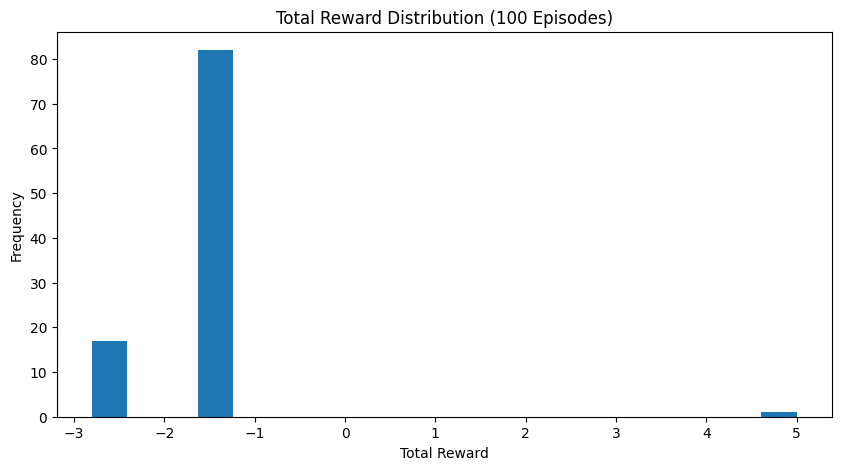

In [7]:
plt.hist(metrics["total_reward"], bins=20)
plt.title("Total Reward Distribution (100 Episodes)")
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.show()


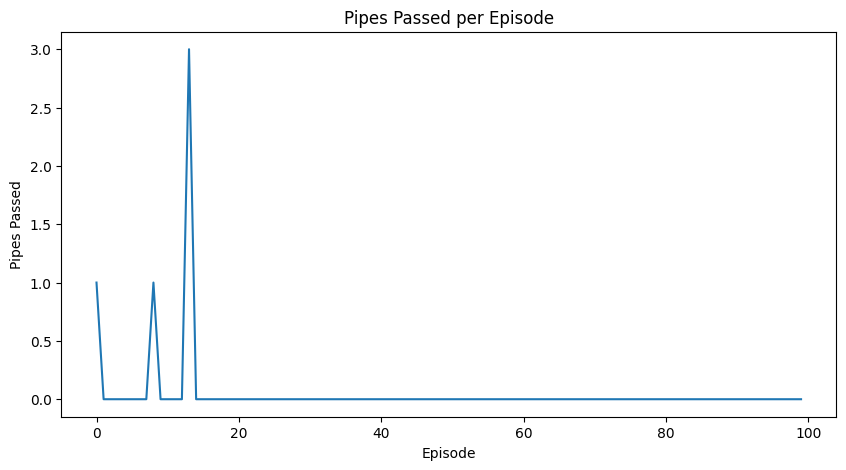

In [8]:
plt.plot(metrics["pipes_passed"])
plt.title("Pipes Passed per Episode")
plt.xlabel("Episode")
plt.ylabel("Pipes Passed")
plt.show()


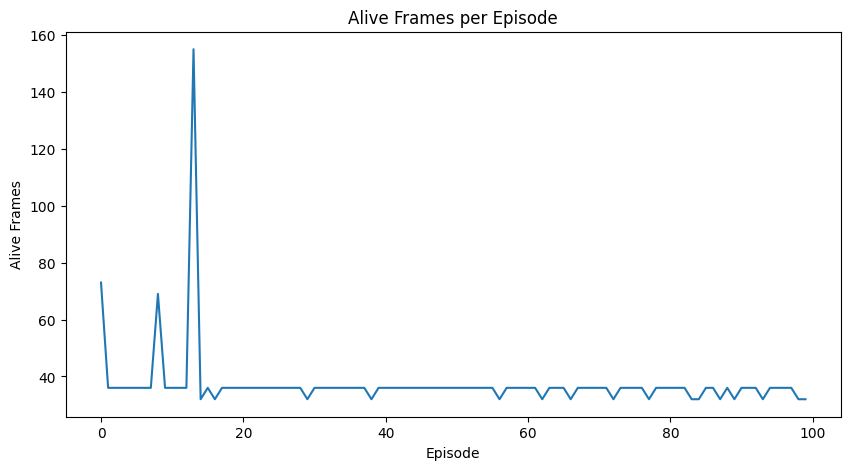

In [9]:
plt.plot(metrics["alive_frames"])
plt.title("Alive Frames per Episode")
plt.xlabel("Episode")
plt.ylabel("Alive Frames")
plt.show()


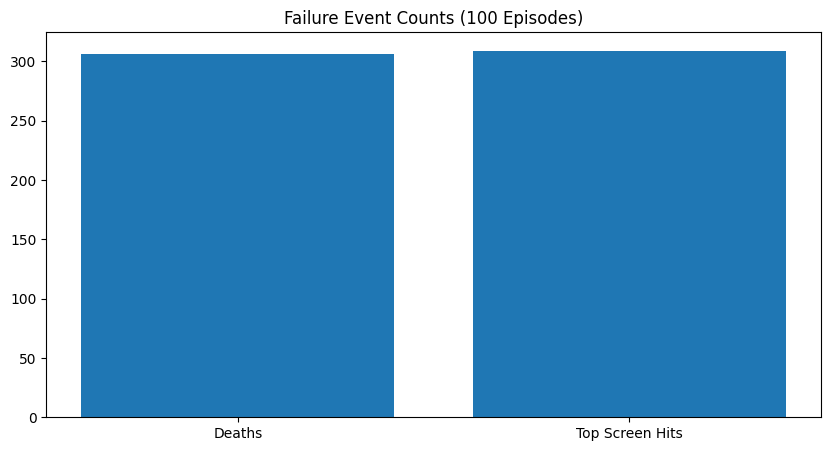

In [10]:
labels = ["Deaths", "Top Screen Hits"]
values = [
    sum(metrics["deaths"]),
    sum(metrics["top_hits"]),
]

plt.bar(labels, values)
plt.title("Failure Event Counts (100 Episodes)")
plt.show()


In [11]:
import json
import pandas as pd
from pathlib import Path

OUTPUT_DIR = Path("metrics")
OUTPUT_DIR.mkdir(exist_ok=True)


ModuleNotFoundError: No module named 'pandas'

In [ ]:
df = pd.DataFrame(metrics)
df.index.name = "episode"

csv_path = OUTPUT_DIR / "episodes.csv"
df.to_csv(csv_path)

print(f"✅ Episode metrics saved to {csv_path}")
